In [1]:
%matplotlib inline

## Euler-Lagrange equation

For a double pendulum system, the Lagrangian with generalized coordinates $\phi_1$ and $\phi_2$ is

$\begin{align}
  \mathcal{L} = T -U
\end{align}$

T = kinetic:

$\begin{align}
   T = \frac{1}{2}(m_1+m_2)L_1^2\dot\phi_1^2 + m_2\dot\phi_1^2\dot\phi_2^2cos(\phi_1-\phi_2)+\frac{1}{2}m_2L_2^2\dot\phi_2^2
  \;.
  \end{align}$

U = potential:

$\begin{align}
    U = (m_1+m_2)gL_1(1-cos(\phi_1))+m_2gL_2(1-cos(\phi_2))
   \;.
   \end{align}$

The Euler-Lagrange equations are:

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad
 \ddot \phi_1 = \frac{(g(2m_1+m_2)sin(\phi_1)+gm_2sin(\phi_1-2\phi_2)+2m_2(L_2\dot\phi_2^2+L_1\dot\phi_1^2cos(\phi_1-\phi_2))
 sin(\phi_1-\phi_2)}{2L_1(m_1+m_2sin(\phi_1-\phi_2)^2)}
  \;.
\end{align}$
$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad
 \ddot \phi_2 = \frac{L_1(m_1+m_2)\dot\phi_1^2+g(m_1+m_2)cos(\phi_1)+L_2m_2\dot\phi_2^2cos(\phi_1-\phi_2)sin(\phi_1-\phi_2)}{L_2(m_1+m_2sin(\phi_1-phi_2)^2}
  \;.
\end{align}$

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [4]:
class LagrangianPendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
    L : float
        length of the simple pendulum
    g : float
        gravitational acceleration at the earth's surface
    mass : float
        mass of pendulum
    mass2 : float
        mass of second pendulum
    L2 : float
        length of second part of pendulum
    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L=1., L2 = 2., mass=1., mass2 = 1., g=1.):
        self.L = L
        self.L2 = L2
        self.g = g
        self.mass = mass
        self.mass2 = mass2
    
    #numerator of the second derivative wrt time of phi1
    #divided into parts
    def num1a(self, h):
        return(self.g*(2*self.mass+self.mass2)*np.sin(h))
    
    def num1b(self, h, i, j,k):
        return (self.g*self.mass2*np.sin(h-2*j))+(2*self.mass2*(self.L2*k**2 + self.L*i**2*np.cos(h-j))*np.sin(h-j))
    
    def num1c(self):
        return
    
    def num1(self, h, i, j, k): #h is the phi1, i is phi1_dot, j is phi2, and k is phi2_dot
        
        return (self.num1a(h)+self.num1b(h,i,j,k))
    
    #denominator of the second derivative wrt time of phi1
    def den1(self, h, j):  #same h and j as above
        
        return (-1/(2*self.L*(self.mass + self.mass2 * np.sin(h-j)**2)))
               
    #numerator of the second derivative wrt time of phi2           
    def num2(self, h, i, j, k): #same as above
               
        return ((self.L*(self.mass + self.mass2)*i**2)+ (self.g*(self.mass + self.mass2)*np.cos(h))+ \
              (self.L2 * self.mass2*k**2*np.cos(h-j)))*np.sin(h-j)
    
    #denominator of the secon derivative wrt time of phi2
    def den2(self, h, j): #same as above
        
        return (1/(self.L2*(self.mass+self.mass2*np.sin(h-j)**2)))
    
    #num1 divided by den1
    def ratio1(self, h, i, j, k): #same variables as above, ratio of num1 to den1
        
        return (self.num1(h, i, j, k) *self.den1(h, j))
    
    #num2 divided by den2
    def ratio2(self, h, i, j, k): #same variables as above, ratio fo num2 to den2
        
        return (self.num2(h, i, j, k) * self.den2(h, j))
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2 dphi2/dt d^2phi2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi(t) and y[1] = dphi/dt
            y[2] = phi2(t) and y[3] = dphi2/dt
            
        Returns
        -------
        
        """
        return [y[1], self.ratio1(y[0], y[1], y[2], y[3]), y[3], self.ratio2(y[0], y[1], y[2], y[3])] 
        #equation for phidot and phidot2
    
    def solve_ode(self, t_pts, phi_0, phi_dot_0, phi2_0, phi2_dot_0, 
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_0, phi_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, atol=abserr, rtol=relerr)
        
        phi, phi_dot, phi2, phi2_dot = solution.y

        return phi, phi_dot, phi2, phi2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):   
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [7]:
# Labels for individual plot axes

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L = 1.
g = 1.
mass = 1.
mass2 = 1.
L2 = 1.

# Instantiate a pendulum 
p1 = LagrangianPendulum(L=L, g=g, mass=mass, mass2 = mass2, L2 = L2)


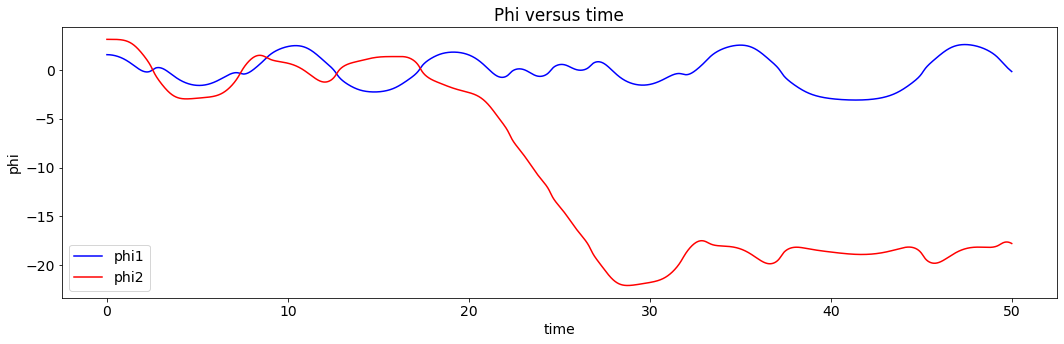

In [8]:
# both plots: initial conditions
phi_0 = (0.5)*np.pi
phi_dot_0 = 0.
phi2_0 = (1.)*np.pi
phi_dot2_0 = 0.
phi, phi_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi_0, phi_dot_0, phi2_0, phi_dot2_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
    
# first plot: phi1 plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start:stop], phi[start:stop], 
            axis_labels=('time', 'phi'), 
            color='blue',
            label= 'phi1', 
            title=r'Phi versus time', 
            ax=ax_a)   

#second plot for phi2
plot_y_vs_x(t_pts[start:stop], phi2[start:stop], 
            axis_labels=None, 
            color='red',
            label='phi2', 
            ax=ax_a)    

fig.tight_layout()

In [9]:
#chaotic for initial condition testing

phi_0C = phi_0 + 1/3400.
phi_dot_0C = phi_dot_0 + 1/3400.
phi2_0C = phi2_0 + 1/3400.
phi_dot2_0C = phi_dot2_0 + 1/3400.
phiC, phi_dotC, phi2C, phi2_dotC = p1.solve_ode(t_pts, phi_0C, phi_dot_0C, phi2_0C, phi_dot2_0C)

'\nComments on plot\nUsing a semilog scale, we see that the difference for the two pendulums increases exponentially with time\nwhich is a characteristics of chaotic motion\n'

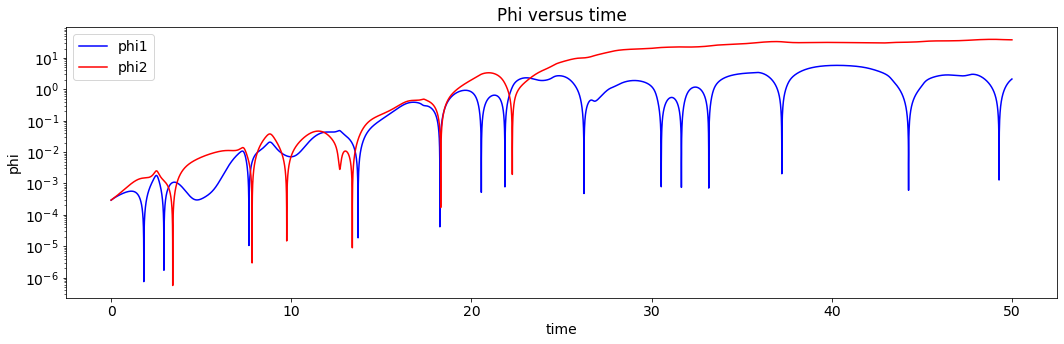

In [14]:
fig2 = plt.figure(figsize=(15,5))
    
# first plot: phi plot 
ax_b = fig2.add_subplot(1,1,1)  

phi_diff1 = np.absolute(phiC-phi)
phi_diff2 = np.absolute(phi2C-phi2)

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start:stop], phi_diff1[start:stop], 
            axis_labels=('time', 'phi'), 
            color='blue',
            label= 'phi1', 
            title=r'Phi versus time', 
            ax=ax_b, semilogy = True)    
plot_y_vs_x(t_pts[start:stop], phi_diff2[start:stop], 
            axis_labels=None, 
            color='red',
            label='phi2', 
            ax=ax_b, semilogy = True) 
fig2.tight_layout() 

"""
Comments on plot
Using a semilog scale, we see that the difference for the two pendulums increases exponentially with time
which is a characteristic of chaotic motion
"""
